___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://www.carrerasenlinea.mx/logos/original/logo-instituto-tecnologico-y-de-estudios-superiores-de-occidente.png" width="150px" height="100px" />


# TERCER EXAMEN PARCIAL
# SIMULACIÓN DE PROCESOS FINANCIEROS

## Nombre: Pablo Ángel Mendoza Aguirre

## Fecha: 21 de Octubre del 2018

## Por: Oscar David Jaramillo Z.

Vamos a suponer que el curso de simulación de procesos financieros es una gran empresa de consultoría financiera que ofrece sus servicios a cualquier tipo de compañía o particular. Supongamos que acuden a nuestra empresa 1 personalidad con el siguiente problema que desean solucionar:
> Empresa joyera que fabrica sus piezas en oro. Esta empresa ha visto afectado sus ingresos debido a las fluctuaciones que ha presentado los últimos meses el precio del oro. Debido a esto, acude a nosotros para intentar mitigar estas fluctuaciones en el precio del oro, usando una adecuada estrategia financiera.
Para cada uno de los clientes, se debe de presentar 4 posibles estrategias de cobertura usando opciones Europeas, Americanas, Barrera y Asiáticas, tipo call ó put. Además de ofrecer al cliente este abanico de posibilidades, ustedes como analistas financieros deben de recomendar la mejor estrategia costo-beneficio (basado en sus cálculos), que debería cada empresa tomar, para cumplir con su objetivo.

In [1]:
#importar los paquetes que se van a usar
import time,math 
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_historical_closes(tickers, start_date=None, end_date=None, freq=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Frecuencia de muestreo por defecto (freq='d')
    # Importamos paquetes necesarios
    import pandas as pd
    pd.core.common.is_list_like = pd.api.types.is_list_like
    import pandas_datareader.data as web  
    # Creamos DataFrame vacío de precios, con el índice de las fechas
    closes = pd.DataFrame(columns = tickers, index=web.YahooDailyReader(symbols=tickers[0], start=start_date, end=end_date, interval=freq).read().index)
    # Agregamos cada uno de los precios con YahooDailyReader
    for ticker in tickers:
        df = web.YahooDailyReader(symbols=ticker, start=start_date, end=end_date, interval=freq).read()
        closes[ticker]=df['Adj Close']
    closes.index_name = 'Date'
    closes = closes.sort_index()
    return closes
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]
def Riemann_approach_sc(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad'):
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    t = t*NbStep
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = pd.DataFrame(K*np.ones([NbStep,NbTraj]), index=t)
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    call = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(Average_t-strike,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima
    mean_est = call.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
#   return np.array([call.iloc[-1].Prima,i1[0],i1[1]])
    return call.iloc[-1].Prima
def Riemann_approach_sp(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad'):
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    t = t*NbStep
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = pd.DataFrame(K*np.ones([NbStep,NbTraj]), index=t)
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    put = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(strike-Average_t,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = put.sem().Prima
    mean_est = put.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
#   return np.array([call.iloc[-1].Prima,i1[0],i1[1]])
    return put.iloc[-1].Prima
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    T = 1
    nu = mu-(sigma**2)/2
    DeltaT = T/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    #for i in range(NbStep):
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    LogSt = np.cumsum(concat,axis=1)
    St = np.exp(LogSt)
    t = np.arange(0,1,DeltaT)
    return St.T,t
def Riemann_approach_c(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad'):
    t1 = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    t = t*NbStep
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = pd.DataFrame(K*np.ones([NbStep,NbTraj]), index=t)
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    call = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(Average_t-strike,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima
    mean_est = call.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t2 = time.time()
    speed = (t2-t1)
    return np.array([call.iloc[-1].Prima,i1[0],i1[1],speed]) 
def Riemann_approach_p(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad'):
    t1 = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    t = t*NbStep
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = pd.DataFrame(K*np.ones([NbStep,NbTraj]), index=t)
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    put = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(strike-Average_t,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = put.sem().Prima
    mean_est = put.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t2 = time.time()
    speed = (t2-t1)
    return np.array([put.iloc[-1].Prima,i1[0],i1[1],speed])
def TRAP_c(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad'):
    t1 = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    t = t*NbStep
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = pd.DataFrame(K*np.ones([NbStep,NbTraj]), index=t)
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    call = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(Average_t-strike,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima
    mean_est = call.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t2 = time.time()
    speed = (t2-t1)
    return np.array([call.iloc[-1].Prima,i1[0],i1[1],speed]) 

In [3]:
closes_ma = get_historical_closes(['F'], '2017-10-17', '2018-11-01',freq='d')
gold = pd.read_csv('/Users/pablomendoza/Downloads/Examen_3/GOLD.csv', header=0, index_col = 'Date')
gold.index = closes_ma.index #spot 1238.60

### Precios del Activo a lo Largo del Tiempo

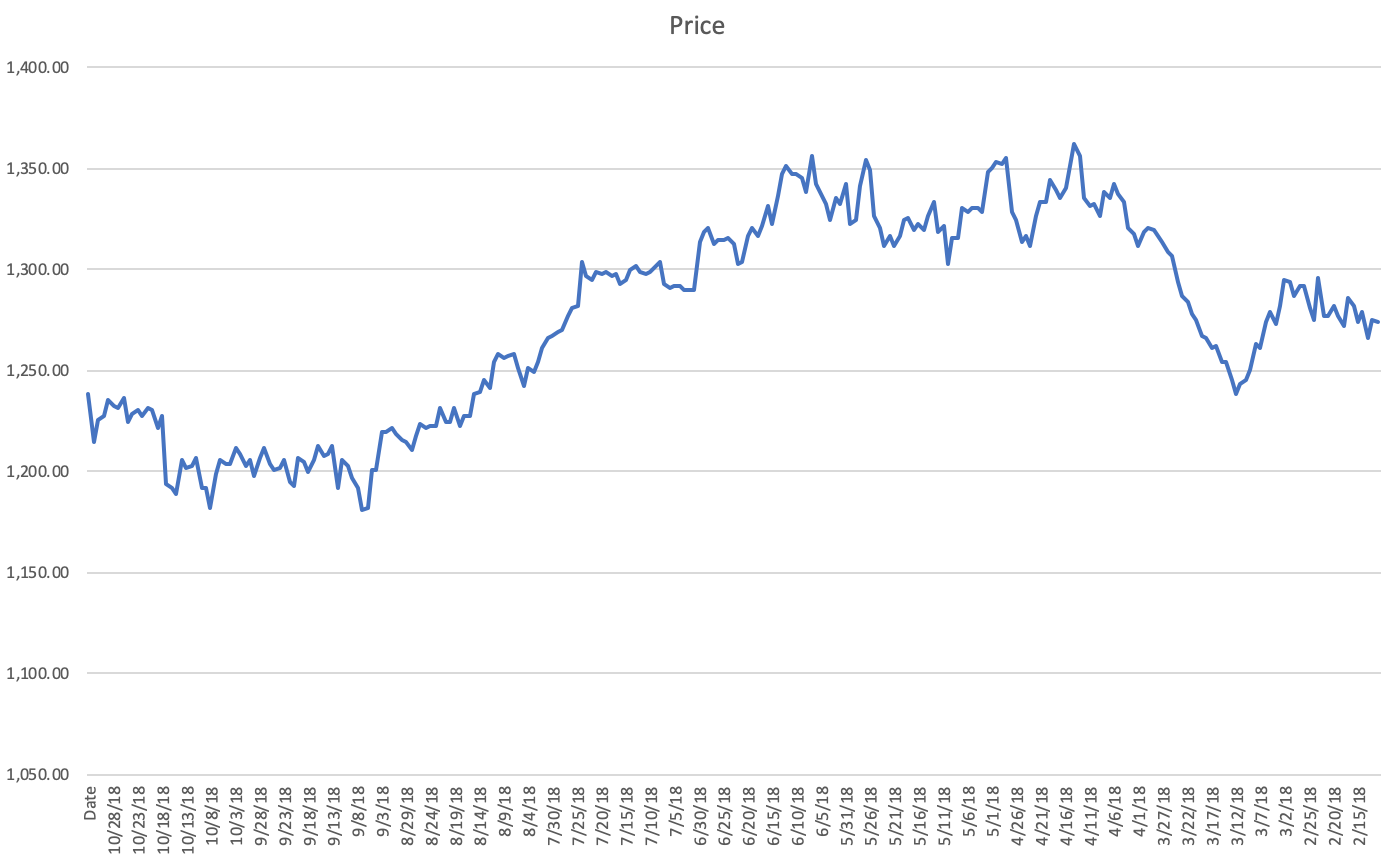

In [4]:
from IPython.display import Image
Image('/Users/pablomendoza/Downloads/Examen_3/imagens.png', width=1000, height=1000)

### Rendimientos de los Activos

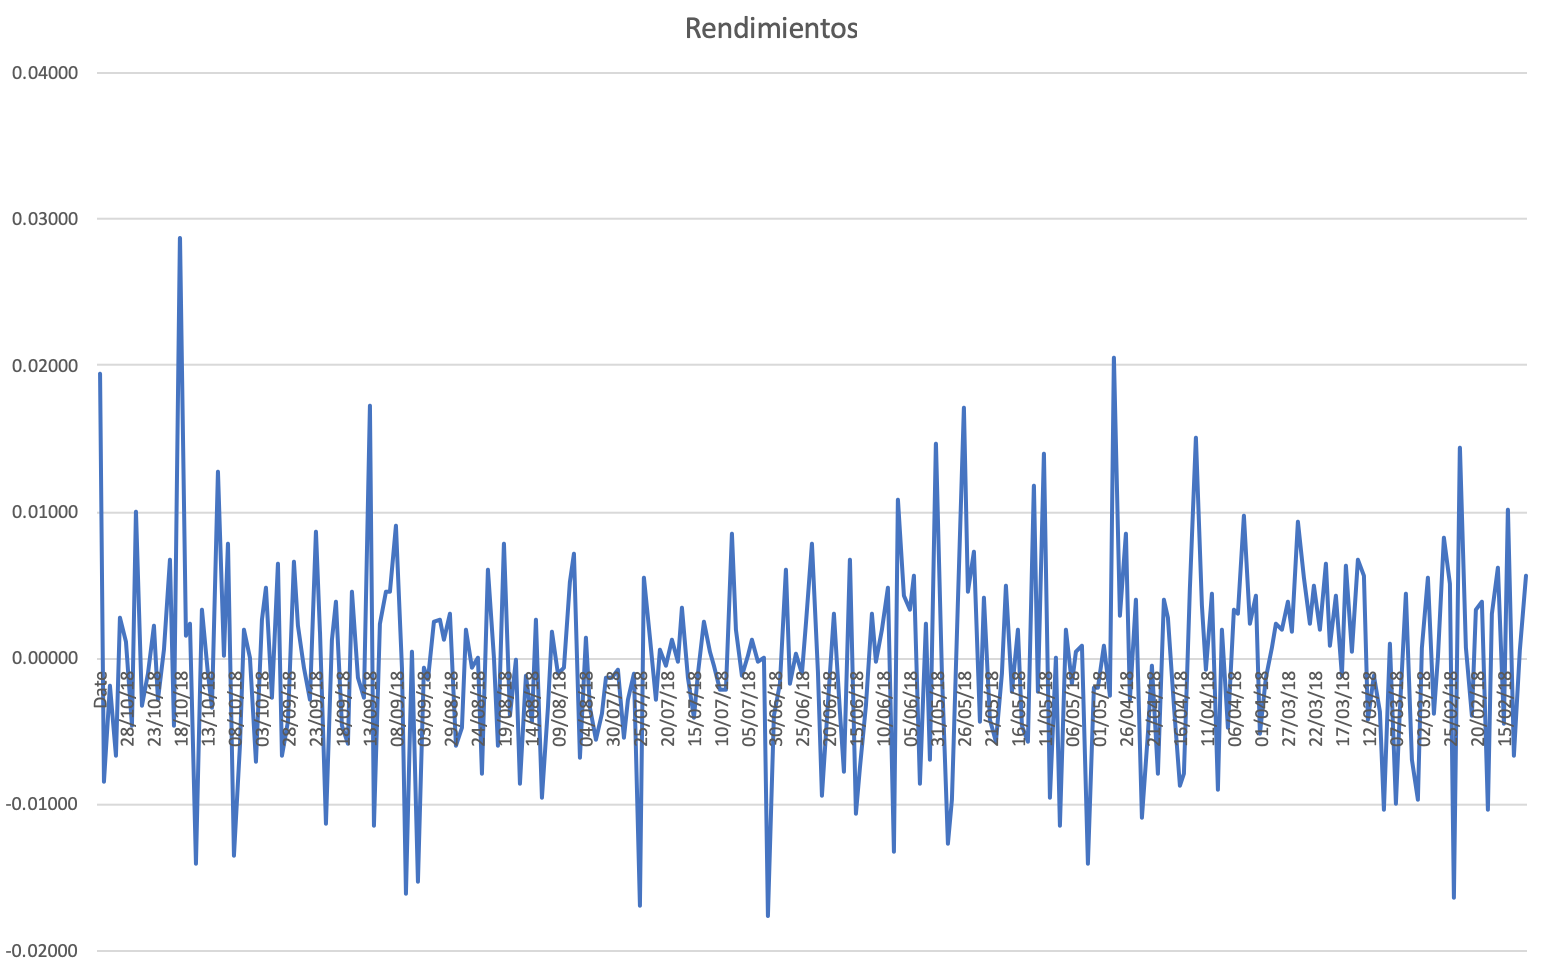

In [5]:
Image('/Users/pablomendoza/Downloads/Examen_3/rend.png', width=1000, height=1000)

### Supuestos

* La empresa busca cubrirse del alza del precio del oro.
* De acuerdo a su análisis financiero la empresa puede pagar un precio de 1,285 pero más allá de ese precio tendrían que incrementar el precio de la joyería y perderían clientes.
* La empresa busca cubrirse por 90 días.
* La empresa busca opciones sencillas pero preferiría un producto estructurado que abarate el costo de la prima aunque eso implique asumir un mayor riesgo.

### CALL Europeo

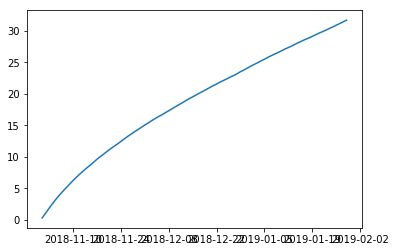

31.67


In [6]:
K= 1285 # strike price
ndays = 90
nscen = 100000
miu = -0.000065
sigma = 0.00658
dates = pd.date_range('2018-11-01', periods = ndays)
S0 = 1273.41 # Condición inicial del precio a simular
r = 0.0273/360 # Tasa diaria
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
strike = pd.DataFrame(K*np.ones([ndays,nscen]), index=dates)
call = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike ,np.zeros([ndays,nscen])).T.mean()}, index=dates)
plt.plot(call)
plt.show()
call_eu = np.round(call.iloc[-1,0],2)
print(call_eu)

### CALL Americano

In [7]:
def min_cuad_americanas(x,y):
    A = np.zeros([len(x),3])
    A[:,0] = np.ones(len(x)).T
    A[:,1] = x.T
    A[:,2] = (x**2).T
    coeficientes = np.dot(np.linalg.pinv(A),y)
    return coeficientes
def Call_Americano(sim_closes,K,r,ndays,nscen):
    a2 = np.array([sim_closes.iloc[j,-1]-K if sim_closes.iloc[j,1]-K > 0 else 0 for j in range(nscen)]) #indica cuales cumplen la condición del PayOff
    for t in range (ndays-1):
        a = a2*np.exp(-r)
        b = np.concatenate(np.array([a != 0])) #guarda en True-False las pocisiones de los que cumplen y no cumplen el PayOff
        c = a[a != 0] #guarda los valores que si cumplen la condición del PayOff
        d = np.array([sim_closes.iloc[j,-2-t] if b[j] == True else 0 for j in range(nscen)]) #toma los valores de un tiempo anterior de los indices guardados con los True-False
        e = d[d != 0] #guarda los valores de la linea anterior diferentes de 0
        f = min_cuad_americanas(e,c) #coeficientes de minimos cuadrados
        g = np.concatenate([f[0]+f[1]*d + f[2]*(d**2)]) #calcular los valores usando los coeficiente obtenidos
        g = np.array([g[j] if g[j] > 0 else 0 for j in range(len(g))])
        h = np.array([d[j]-K if d[j]-K >= g[j] else a[j] for j in range(nscen)]) # resultado comparando con los del tiempo no anterior
        h = np.array([h[j] if h[j] < K else 0 for j in range(len(h))])
        a2 = h
    return np.exp(-r)*h.mean()

In [8]:
Call_Americ = Call_Americano(sim_closes.T,K,r,ndays,nscen) 
Call_Americ

3.1746395153630838

### Call Asiatica

In [9]:
NbTraj = [100000]#
NbStep = [90]
r = 0.0273
K = 1285      # Strike price
T = 90/360# Tiempo de cierre - años
M = list(map(lambda N_tra:list(map(lambda N_ste:TRAP_c(K,r,S0,N_tra,N_ste,sigma),NbStep)),NbTraj))
asiatica = M[0][0][0]
print(asiatica)

6.002855446904653


### Call KO Barrera (Down & Out)

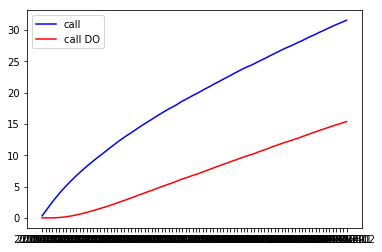

Prima de la Opción Calculada Call DO
Prima_do    15.388
Name: 2019-02-12, dtype: float64
Intervalo de Confianza de 90%
(14.971639317267066, 15.804230241552062)
(14.971643173808161, 15.804226385010967)


In [10]:
r = 0.0273/360
B = 1260  # precio de barrera
ndays = 90
nscen = 100000
dates = pd.date_range('2018-11-15', periods = ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (S0*np.exp(sim_ret.cumsum()))
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes<barrier).cumsum()>0
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
call = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros((ndays,nscen))).T.mean()},index=dates)
calldo = pd.DataFrame({'Prima_do':np.exp(-r*ndays)*(I*np.fmax(sim_closes-strike,np.zeros((ndays,nscen)))).T.mean()},index=dates)
plt.plot(call, c = 'b')
plt.plot(calldo,c = 'r')
plt.legend(['call','call DO'])
plt.show()
print('Prima de la Opción Calculada Call DO')
CDO_norm = calldo.iloc[-1]
print(calldo.iloc[-1])
print('Intervalo de Confianza de 90%')
confianza = 0.90
sigma_est = sim_closes.iloc[-1].sem()
mean_est = calldo.iloc[-1].Prima_do
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

### BOOMERANG

Long Call Vanilla Strike en 1285

Short Put KI Stike en 1275, Barrrera en 1260

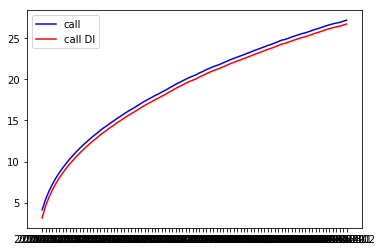

Prima de la Opción Calculada Call DI
Prima_di    26.722
Name: 2019-02-12, dtype: float64
Intervalo de Confianza de 90%
(26.30170140032054, 27.141300084923756)
(26.30170528932141, 27.141296195922884)


In [11]:
K = 1275
B = 1260  # precio de barrera
ndays = 90
nscen = 100000
dates = pd.date_range('2018-11-15', periods = ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (S0*np.exp(sim_ret.cumsum()))
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes>barrier).cumsum()>0
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
call = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes,np.zeros((ndays,nscen))).T.mean()},index=dates)
calldi = pd.DataFrame({'Prima_di':np.exp(-r*ndays)*(I*np.fmax(strike-sim_closes,np.zeros((ndays,nscen)))).T.mean()},index=dates)
plt.plot(call, c = 'b')
plt.plot(calldi,c = 'r')
plt.legend(['call','call DI'])
plt.show()
print('Prima de la Opción Calculada Call DI')
CDI_norm_1 = calldi.iloc[-1]
print(calldi.iloc[-1])
print('Intervalo de Confianza de 90%')
confianza = 0.90
sigma_est = sim_closes.iloc[-1].sem()
mean_est = calldi.iloc[-1].Prima_di
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

### SHARK de Compra

Long Call Vanilla Strike en 1285

Short Put KI Stike en 1285, Barrrera en 1260

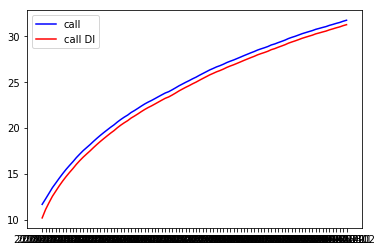

Prima de la Opción Calculada Call DI
Prima_di    31.272
Name: 2019-02-12, dtype: float64
Intervalo de Confianza de 90%
(30.85473212514465, 31.689042682088036)
(30.854735989651044, 31.689038817581643)


In [12]:
K = 1285
B = 1260  # precio de barrera
ndays = 90
nscen = 100000
dates = pd.date_range('2018-11-15', periods = ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (S0*np.exp(sim_ret.cumsum()))
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes>barrier).cumsum()>0
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
call = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes,np.zeros((ndays,nscen))).T.mean()},index=dates)
calldi = pd.DataFrame({'Prima_di':np.exp(-r*ndays)*(I*np.fmax(strike-sim_closes,np.zeros((ndays,nscen)))).T.mean()},index=dates)
plt.plot(call, c = 'b')
plt.plot(calldi,c = 'r')
plt.legend(['call','call DI'])
plt.show()
print('Prima de la Opción Calculada Call DI')
CDI_norm_2 = calldi.iloc[-1]
print(calldi.iloc[-1])
print('Intervalo de Confianza de 90%')
confianza = 0.90
sigma_est = sim_closes.iloc[-1].sem()
mean_est = calldi.iloc[-1].Prima_di
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

### Estrategias Estructuradas y No Estructuradas

In [13]:
val = S0
tabla_estrategia=np.array(['Europeo','Americano','Asiatica','Barrera DO','Boomerang','Shark'])
tabla_tipo= np.array(['CALL','CALL','CALL','CALL','De Compra','De Compra'])
tabla_k= np.array(['1285','1285','1285','1285','1275','1285'])
tabla_barrera= np.array(['-','-','-','1260','1260','1260'])
primas= np.array([call_eu*val*90/360,Call_Americ*val*90/360,asiatica*val*90/360,CDO_norm*val*90/360,(call_eu-CDI_norm_1)*val*90/360,(call_eu-CDI_norm_2)*val*90/360])
tabla = pd.DataFrame(columns=['Tipo','Strike','Barrera','Prima'], index = tabla_estrategia)
tabla['Tipo'] = tabla_tipo
tabla['Strike'] = tabla_k
tabla['Barrera'] = tabla_barrera
tabla['Prima'] = primas
tabla

,Tipo,Strike,Barrera,Prima
Europeo,CALL,1285,-,10082.224
Americano,CALL,1285,-,1010.654
Asiatica,CALL,1285,-,1911.024
Barrera DO,CALL,1285,1260,4898.788
Boomerang,De Compra,1275,1260,1575.367
Shark,De Compra,1285,1260,126.740


<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Zuluaga.
</footer>